<a href="https://colab.research.google.com/github/lee-euijin/AppleFarm/blob/main/Model/skeleton_preprocessing_and_Model_Learning_our_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data upload

In [ ]:
# mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip
import zipfile, shutil

dataset = '/content/drive/My Drive/학교 수업 자료/딥러닝/Project/static_data.zip'
dst_path = '/content/static_data'
dst_file = os.path.join(dst_path, 'static_data.zip')

if not os.path.exists(dst_path):
  os.makedirs(dst_path)

shutil.copy(dataset, dst_file)

with zipfile.ZipFile(dst_file, 'r') as file:
  file.extractall(dst_path)

Mounted at /content/gdrive


In [ ]:
import os
imagepaths = []

for dirname, _, filenames in os.walk('/content/static_data'):
  for filename in filenames:
    path = os.path.join(dirname, filename)
    if path.endswith("png"):
      imagepaths.append(path)

print(len(imagepaths))
print(imagepaths[0])

40000
/content/static_data/leapgestrecog/leapGestRecog/02/07_ok/frame_02_07_0145.png


In [ ]:
# google drive에 directory 추가
dir_path = '/content/drive/My Drive/학교 수업 자료/딥러닝/Project/static_skeleton_data'

for path in imagepaths[:19999]:
  splitted = path.split("/")

  # 없으면 directory 추가
  dir = os.path.join(dir_path, splitted[5])

  if not os.path.exists(dir):
    os.makedirs(dir)

  dir = os.path.join(dir_path, splitted[5], splitted[6])

  if not os.path.exists(dir):
    os.makedirs(dir)

NameError: ignored

## Data Preprocessing

In [ ]:
!pip install mediapipe opencv-python

     |████████████████████████████████| 36.1MB 88kB/s 


### Data Preprocessing and Saving

In [ ]:
# 최초 save 이후에는 이 셀 실행하지 않음!
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import mediapipe as mp
from google.colab.patches import cv2_imshow

new_path = []

# 저장을 위한 path 생성
for path in imagepaths[:19999]:
  splitted = path.split("/")
  temp = '/' + splitted[5] + '/' + splitted[6] + '/' + splitted[7]
  new_path.append(temp)

# train data preprocessing and save
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
  for idx in range(19999):
    # read an image, flip it around y-axis for correct handedness output
    image = cv.imread(imagepaths[idx])
    # convert the bgr image to rgb before processing
    results = hands.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))

    # print handedness and draw hand landmarks on the image
    # print('Handedness:', results.multi_handedness)
    if not results.multi_hand_landmarks:
      continue
    image_height, image_width, _ = image.shape
    annotated_image = image.copy()

    # landmark만 그릴 image
    landmark_image = np.zeros(image.shape)
    for hand_landmarks in results.multi_hand_landmarks:
      '''print('hand_landmarks:', hand_landmarks)
      print(
          f'Index finger tip coordinates: (',
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height}'
      )'''
      mp_drawing.draw_landmarks(
          landmark_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    '''# imshow
    cv2_imshow(annotated_image)
    cv2_imshow(landmark_image)'''
    
    # save
    cv.imwrite(dir_path + new_path[idx], landmark_image)

IndexError: ignored

* index를 잘못 설정하여 에러가 발생했지만, 정상적으로 모두 저장되었다.

### 우리가 만든 training data 추가, path 확인

In [ ]:
import os
dir_path = '/content/drive/My Drive/static_skeleton_data/12'
skeletonpaths = []

for dirname, _, filenames in os.walk(dir_path):
  for filename in filenames:
    path = os.path.join(dirname, filename)
    
    if path.endswith("png"):
      skeletonpaths.append(path)

print(len(skeletonpaths)) # 6766개 데이터 유실
print(skeletonpaths[0])

2623
/content/drive/My Drive/static_skeleton_data/12/01_palm/frame_00_12_0001.png


## Training

In [ ]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout

In [ ]:
# Creating trainig set and labels
X = []
y = []

for path in skeletonpaths[:]:
  # image data
  img = cv.imread(path)
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = cv.resize(img, (128, 128))
  X.append(img)
  print(len(X))

  # labels
  category = path.split("/")[6] # path에서 6번째가 label
  label = int(category.split("_")[0][1])
  y.append(label)

X = np.array(X)
X = X.reshape(len(skeletonpaths), 128, 128, 1)
y = np.array(y)

print("이미지 개수 : ", len(X))
print("라벨 개수 : ", len(y))
print(y[0], skeletonpaths[0])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
# data 저장
np.save('/content/drive/My Drive/made_new/input_data_made.npy', X)
np.save('/content/drive/My Drive/made_new/label_data_made.npy', y)

print(len(X))
print(len(y))
print(X[0].shape)

# data 저장 잘 됐는지 확인
X_ = np.load('/content/drive/My Drive/made_new/input_data_made.npy')

2623
2623
(128, 128, 1)


In [ ]:
# data 불러오기
X = []
y = []

X = np.load('content/drive/My Drive/made_new/input_data_made.npy')
y = np.load('content/drive/My Drive/made_new/label_data_made.npy')

print(len(X))
print(len(y))
print(X[0].shape)

In [ ]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

# model
model = Sequential()
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=2, 
          validation_data=(X_test, y_test))

Epoch 1/10
33/33 - 46s - loss: 2.0454 - accuracy: 0.4857 - val_loss: 0.8290 - val_accuracy: 0.7371
Epoch 2/10
33/33 - 1s - loss: 0.5732 - accuracy: 0.8141 - val_loss: 0.3617 - val_accuracy: 0.8838
Epoch 3/10
33/33 - 1s - loss: 0.3058 - accuracy: 0.8999 - val_loss: 0.1707 - val_accuracy: 0.9448
Epoch 4/10
33/33 - 1s - loss: 0.1306 - accuracy: 0.9623 - val_loss: 0.1226 - val_accuracy: 0.9676
Epoch 5/10
33/33 - 1s - loss: 0.0639 - accuracy: 0.9819 - val_loss: 0.1271 - val_accuracy: 0.9714
Epoch 6/10
33/33 - 1s - loss: 0.0563 - accuracy: 0.9828 - val_loss: 0.0971 - val_accuracy: 0.9752
Epoch 7/10
33/33 - 1s - loss: 0.0495 - accuracy: 0.9857 - val_loss: 0.1182 - val_accuracy: 0.9695
Epoch 8/10
33/33 - 1s - loss: 0.0338 - accuracy: 0.9914 - val_loss: 0.1002 - val_accuracy: 0.9733
Epoch 9/10
33/33 - 1s - loss: 0.0196 - accuracy: 0.9933 - val_loss: 0.1550 - val_accuracy: 0.9638
Epoch 10/10
33/33 - 1s - loss: 0.0165 - accuracy: 0.9957 - val_loss: 0.1419 - val_accuracy: 0.9714


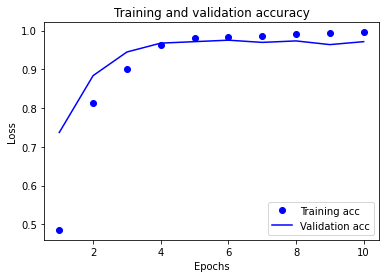

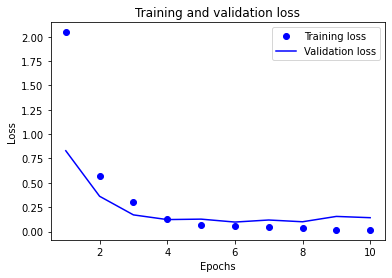

In [ ]:
# plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# model save
from tensorflow import keras
model.save('/content/drive/My Drive/model_new/model_made.h5')